# [Neuralink Time Series Forecasting](https://www.tensorflow.org/tutorials/structured_data/time_series)


## Imports


In [24]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from glob import glob
import scipy.io
import IPython
import time

## Configure Tensorflow


In [4]:
# Identify if the GPU is detected
# tf.config.list_physical_devices()

# Identify if the GPU is being used.
# tf.debugging.set_log_device_placement(False)

## Import Data


In [2]:
data_dir = "../../data/"
data_file_l = glob(data_dir + "*.wav")

In [3]:
rate, data = scipy.io.wavfile.read(data_file_l[0])

In [4]:
data_df = pd.DataFrame(data, columns=["Amplitude"])

In [5]:
time = np.arange(0, len(data_df) / rate, (1 / rate))

In [6]:
time

array([0.00000000e+00, 5.12006554e-05, 1.02401311e-04, ...,
       5.05329988e+00, 5.05335108e+00, 5.05340228e+00])

In [7]:
data_df.insert(loc=1, column="Time", value=time, allow_duplicates=True)

In [8]:
data_df = data_df.reindex(columns=["Time", "Amplitude"])

In [9]:
data_df.index.name = "Sample Number"

<Axes: title={'center': 'Raw Neural Signal'}, xlabel='Time [s]'>

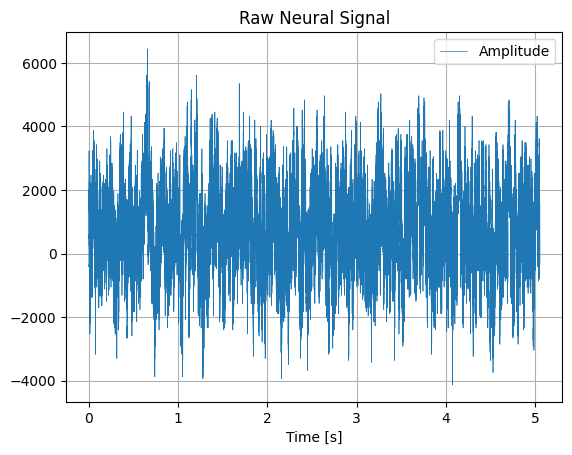

In [10]:
data_df.plot(
    xlabel="Time [s]", x="Time", grid=True, linewidth=0.5, title="Raw Neural Signal"
)

In [11]:
data_df.__len__()

98699

In [12]:
df = data_df.drop("Time", axis=1)

In [13]:
n = df.__len__()

## Defining Training, Validation, & Test Sets


In [14]:
column_indices = {name: i for i, name in enumerate(df.columns)}

train_df = df[0 : int(n * 0.7)]
val_df = df[int(n * 0.7) : int(n * 0.9)]
test_df = df[int(n * 0.9) :]

num_features = df.shape[1]

In [15]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

/var/folders/km/lr9wgyjj0z737tmwxblc5d980000gn/T/ipykernel_1307/2004759091.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df.keys(), rotation=90)


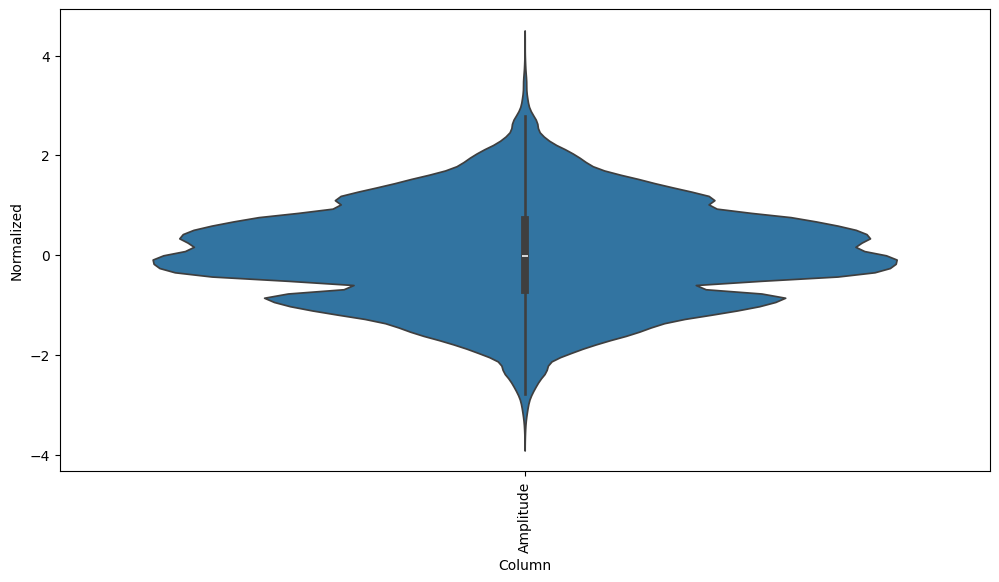

In [16]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name="Column", value_name="Normalized")
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x="Column", y="Normalized", data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [17]:
class WindowGenerator:
    def __init__(
        self,
        input_width,
        label_width,
        shift,
        train_df=train_df,
        val_df=val_df,
        test_df=test_df,
        label_columns=None,
    ):
        # Store the raw data
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {
                name: i for i, name in enumerate(label_columns)
            }
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return "\n".join(
            [
                f"Total window size: {self.total_window_size}",
                f"Input indices: {self.input_indices}",
                f"Label indices: {self.label_indices}",
                f"Label column name(s): {self.label_columns}",
            ]
        )

In [18]:
w1 = WindowGenerator(
    input_width=24, label_width=1, shift=24, label_columns=["Amplitude"]
)

In [19]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1, label_columns=["Amplitude"])

In [20]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1,
        )

    # Slicing doesn't preserve static shape information, so set the shapes manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels


WindowGenerator.split_window = split_window

In [21]:
# Stack three slices, the length of the total window.
example_window = tf.stack(
    [
        np.array(train_df[: w2.total_window_size]),
        np.array(train_df[100 : 100 + w2.total_window_size]),
        np.array(train_df[200 : 200 + w2.total_window_size]),
    ]
)

example_inputs, example_labels = w2.split_window(example_window)

print("All shapes are: (batch, time, features)")
print(f"Window shape: {example_window.shape}")
print(f"Inputs shape: {example_inputs.shape}")
print(f"Labels shape: {example_labels.shape}")

All shapes are: (batch, time, features)
Window shape: (3, 7, 1)
Inputs shape: (3, 6, 1)
Labels shape: (3, 1, 1)


2024-09-05 14:42:56.873620: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-09-05 14:42:56.873653: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-09-05 14:42:56.873668: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-09-05 14:42:56.873691: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-05 14:42:56.873710: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [22]:
w2.example = example_inputs, example_labels

In [23]:
def plot(self, model=None, plot_col="Amplitude", max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n + 1)
        plt.ylabel(f"{plot_col} [normed]")
        plt.plot(
            self.input_indices,
            inputs[n, :, plot_col_index],
            label="Inputs",
            marker=".",
            zorder=-10,
        )

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(
            self.label_indices,
            labels[n, :, label_col_index],
            edgecolors="k",
            label="Labels",
            c="#2ca02c",
            s=64,
        )
        if model is not None:
            predictions = model(inputs)
            plt.scatter(
                self.label_indices,
                predictions[n, :, label_col_index],
                marker="X",
                edgecolors="k",
                label="Predictions",
                c="#ff7f0e",
                s=64,
            )

        if n == 0:
            plt.legend()

    plt.xlabel("Time [h]")


WindowGenerator.plot = plot

In [24]:
w2.label_columns_indices

{'Amplitude': 0}

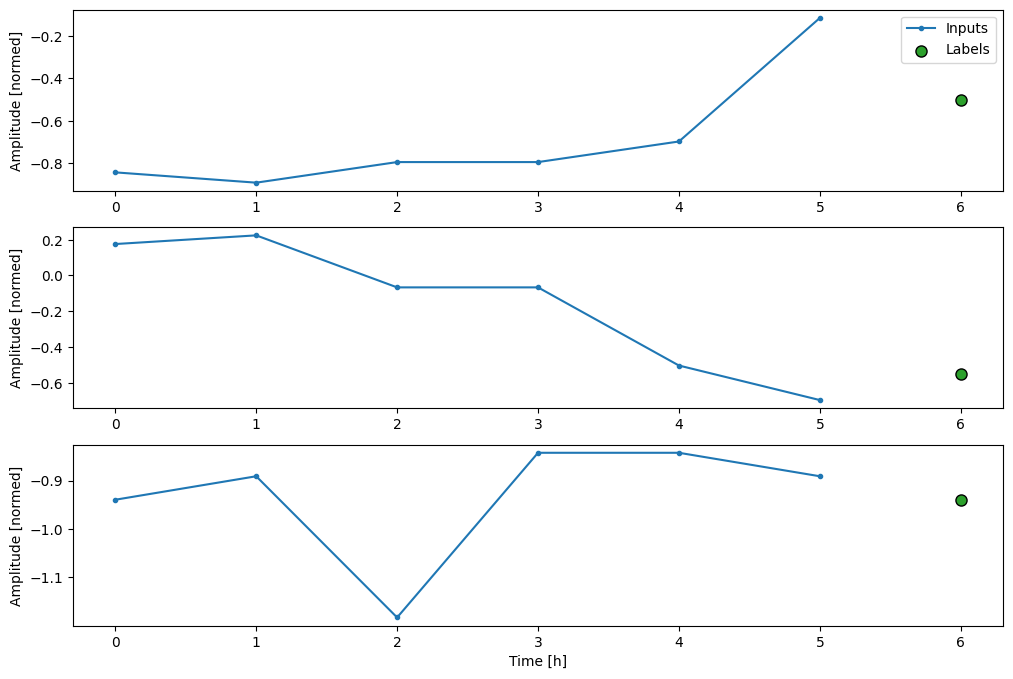

In [25]:
w2.plot()

In [26]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,
    )
    ds = ds.map(self.split_window)

    return ds


WindowGenerator.make_dataset = make_dataset

In [27]:
@property
def train(self):
    return self.make_dataset(self.train_df)


@property
def val(self):
    return self.make_dataset(self.val_df)


@property
def test(self):
    return self.make_dataset(self.test_df)


@property
def example(self):
    """get and cache an example batch of `inputs, labels` for ploting."""
    result = getattr(self, "_example", None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result


WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [28]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [29]:
for example_inputs, example_labels in w2.train.take(1):
    print(f"Inputs shape (batch, time, features): {example_inputs.shape}")
    print(f"Labels shape (batch, time, features): {example_labels.shape}")

Inputs shape (batch, time, features): (32, 6, 1)
Labels shape (batch, time, features): (32, 1, 1)


2024-09-05 14:43:06.937064: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Single Step Model


In [30]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1, label_columns=["Amplitude"]
)
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Amplitude']

In [31]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f"Inputs shape (batch, time, features): {example_inputs.shape}")
    print(f"Labels shape (batch, time, features): {example_labels.shape}")

Inputs shape (batch, time, features): (32, 1, 1)
Labels shape (batch, time, features): (32, 1, 1)


2024-09-05 14:43:10.613516: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Baseline


In [32]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [33]:
baseline = Baseline(label_index=column_indices["Amplitude"])

baseline.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()],
)

val_performance = {}
performance = {}
val_performance["Baseline"] = baseline.evaluate(
    single_step_window.val, return_dict=True
)
performance["Baseline"] = baseline.evaluate(
    single_step_window.test, verbose=0, return_dict=True
)

 21/617 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0674 - mean_absolute_error: 0.2019    

2024-09-05 14:43:14.633089: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


617/617 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0872 - mean_absolute_error: 0.2333


In [34]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1, label_columns=["Amplitude"]
)
wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['Amplitude']

In [35]:
print("Input shape:", wide_window.example[0].shape)
print("Output shape:", baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 1)
Output shape: (32, 24, 1)


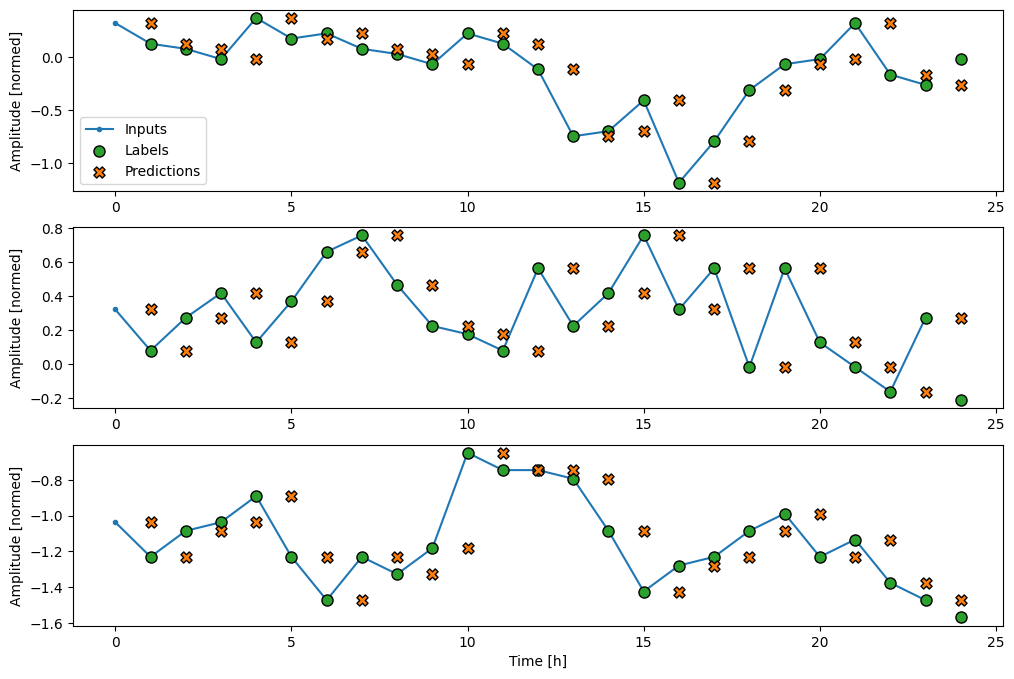

In [36]:
wide_window.plot(baseline)

### Linear Model


In [37]:
linear = tf.keras.Sequential([tf.keras.layers.Dense(units=1)])

In [38]:
print("Input shape:", single_step_window.example[0].shape)
print("Output shape:", linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 1)
Output shape: (32, 1, 1)


In [39]:
MAX_EPOCHS = 20


def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=patience, mode="min"
    )

    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=[tf.keras.metrics.MeanAbsoluteError()],
    )

    history = model.fit(
        window.train,
        epochs=MAX_EPOCHS,
        validation_data=window.val,
        callbacks=[early_stopping],
    )
    return history

In [40]:
history = compile_and_fit(linear, single_step_window)

val_performance["Linear"] = linear.evaluate(single_step_window.val, return_dict=True)
performance["Linear"] = linear.evaluate(
    single_step_window.test, verbose=0, return_dict=True
)

Epoch 1/20
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.2167 - mean_absolute_error: 0.3553 - val_loss: 0.0865 - val_mean_absolute_error: 0.2336
Epoch 2/20
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0859 - mean_absolute_error: 0.2327 - val_loss: 0.0865 - val_mean_absolute_error: 0.2336
Epoch 3/20
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0857 - mean_absolute_error: 0.2325 - val_loss: 0.0865 - val_mean_absolute_error: 0.2337
Epoch 4/20
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0858 - mean_absolute_error: 0.2327 - val_loss: 0.0865 - val_mean_absolute_error: 0.2337
617/617 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0861 - mean_absolute_error: 0.2334


In [41]:
print("Input shape:", wide_window.example[0].shape)
print("Output shape:", wide_window.example[0].shape)

Input shape: (32, 24, 1)
Output shape: (32, 24, 1)


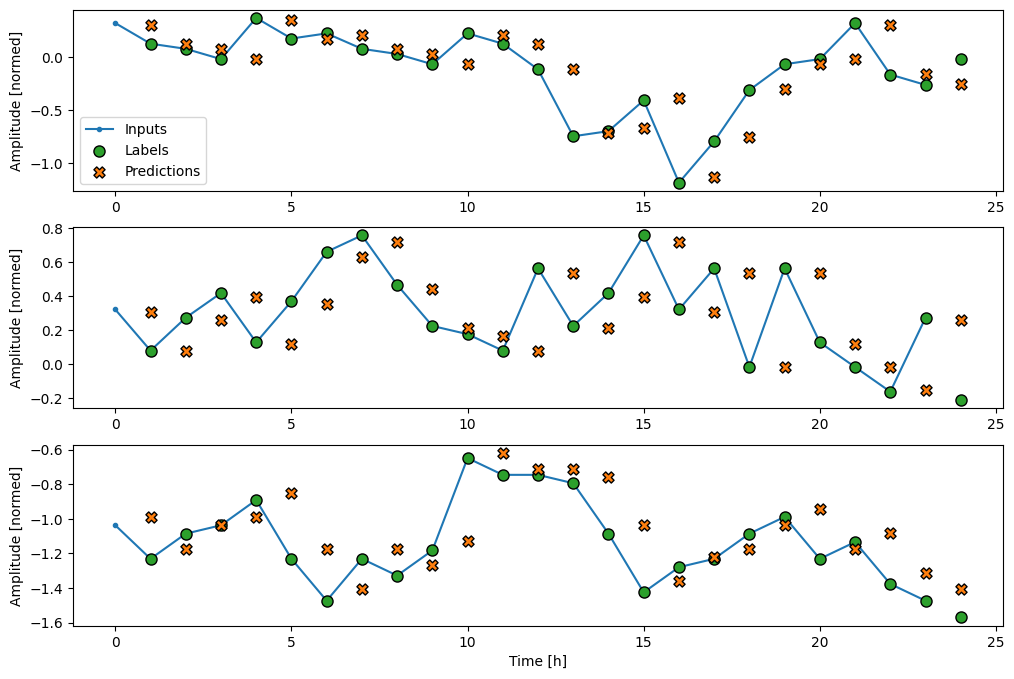

In [42]:
wide_window.plot(linear)

In [43]:
linear.layers[0].kernel[:, 0].numpy()

array([0.951967], dtype=float32)

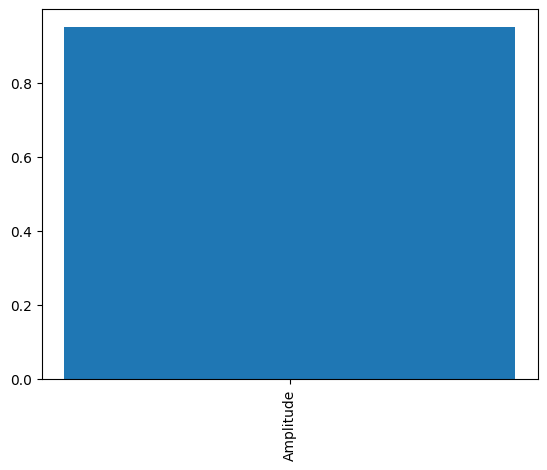

In [45]:
# Visualizing the model's weights assigned to each input

plt.bar(x=range(len(train_df.columns)), height=linear.layers[0].kernel[:, 0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

### Dense


In [46]:
dense = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(units=64, activation="relu"),
        tf.keras.layers.Dense(units=64, activation="relu"),
        tf.keras.layers.Dense(units=1),
    ]
)

history = compile_and_fit(dense, single_step_window)

val_performance["Dense"] = dense.evaluate(single_step_window.val, return_dict=True)
performance["Dense"] = dense.evaluate(
    single_step_window.test, verbose=0, return_dict=True
)

Epoch 1/20
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - loss: 0.1250 - mean_absolute_error: 0.2618 - val_loss: 0.0872 - val_mean_absolute_error: 0.2348
Epoch 2/20
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 0.0881 - mean_absolute_error: 0.2355 - val_loss: 0.0872 - val_mean_absolute_error: 0.2349
Epoch 3/20
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 0.0883 - mean_absolute_error: 0.2358 - val_loss: 0.0875 - val_mean_absolute_error: 0.2354
617/617 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0874 - mean_absolute_error: 0.2354


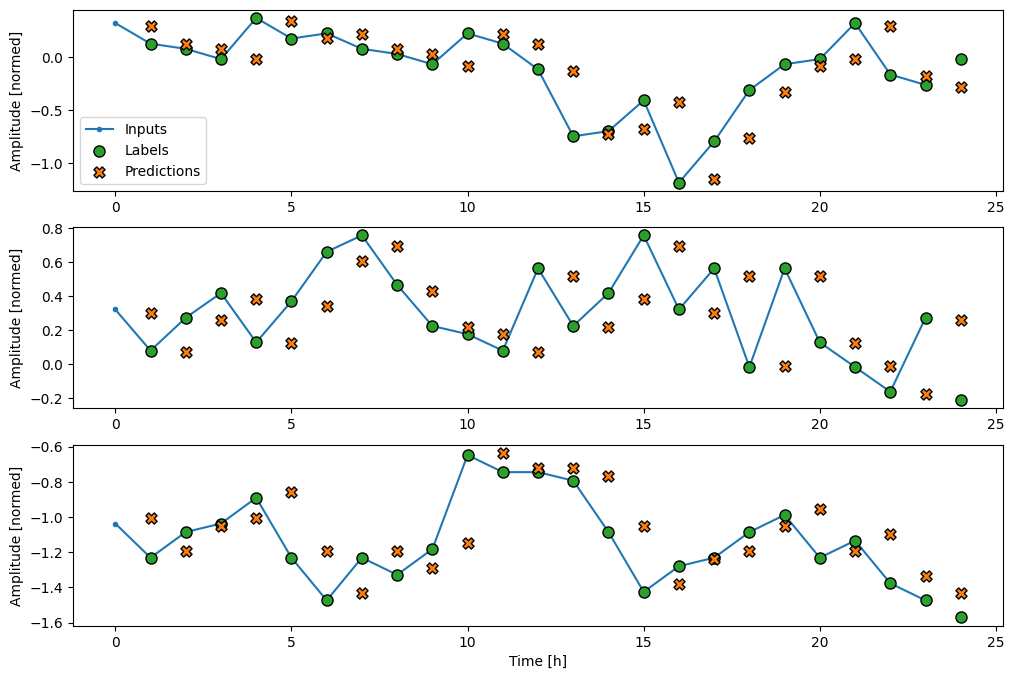

In [47]:
wide_window.plot(dense)

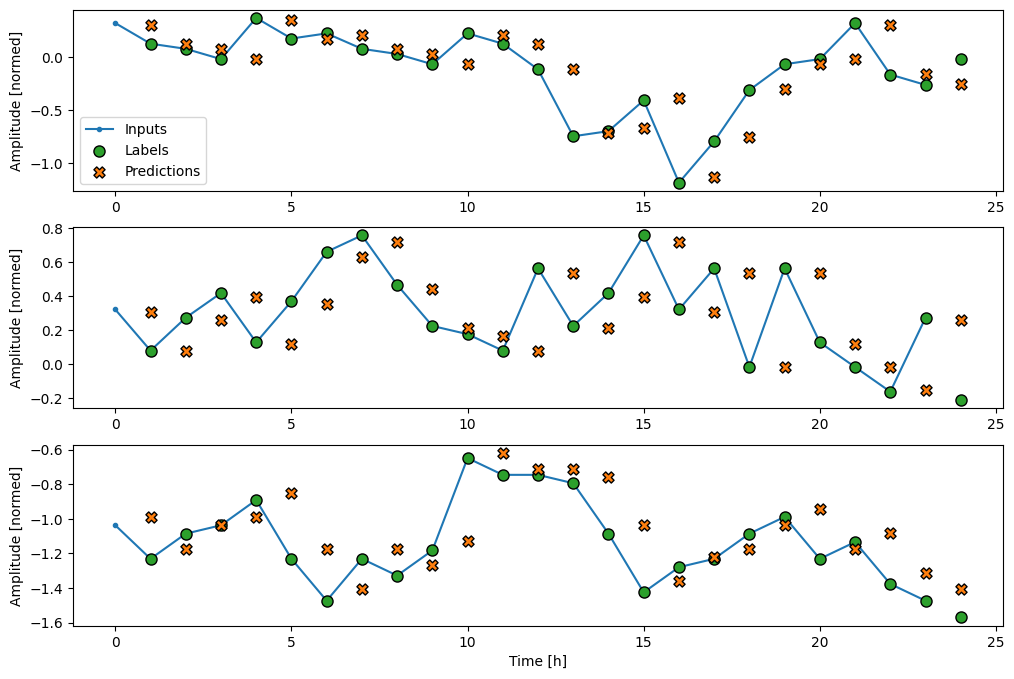

In [48]:
wide_window.plot(linear)

### Multi-step dense


In [49]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH, label_width=1, shift=1, label_columns=["Amplitude"]
)
conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['Amplitude']

Text(0.5, 0.98, 'Given 3 hours of inputs, predict 1 hour into the future.')

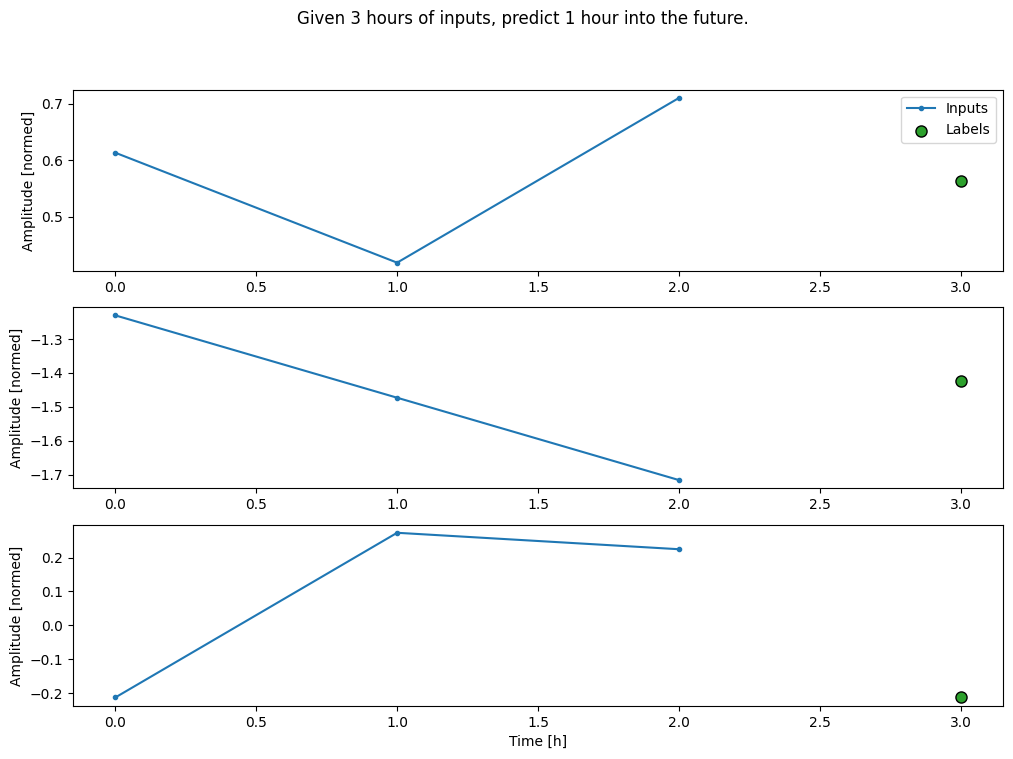

In [50]:
conv_window.plot()
plt.suptitle("Given 3 hours of inputs, predict 1 hour into the future.")

In [51]:
multi_step_dense = tf.keras.Sequential(
    [
        # Shape: (time, features) => (time*features)
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=32, activation="relu"),
        tf.keras.layers.Dense(units=32, activation="relu"),
        tf.keras.layers.Dense(units=1),
        # Add back the time dimension.
        # Shape: (outputs) => (1, outputs)
        tf.keras.layers.Reshape([1, -1]),
    ]
)

In [52]:
print("Input shape:", conv_window.example[0].shape)
print("Output shape:", multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 1)
Output shape: (32, 1, 1)


In [53]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance["Multi step dense"] = multi_step_dense.evaluate(
    conv_window.val, return_dict=True
)
performance["Multi step dense"] = multi_step_dense.evaluate(
    conv_window.test, verbose=0, return_dict=True
)

617/617 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0860 - mean_absolute_error: 0.2331


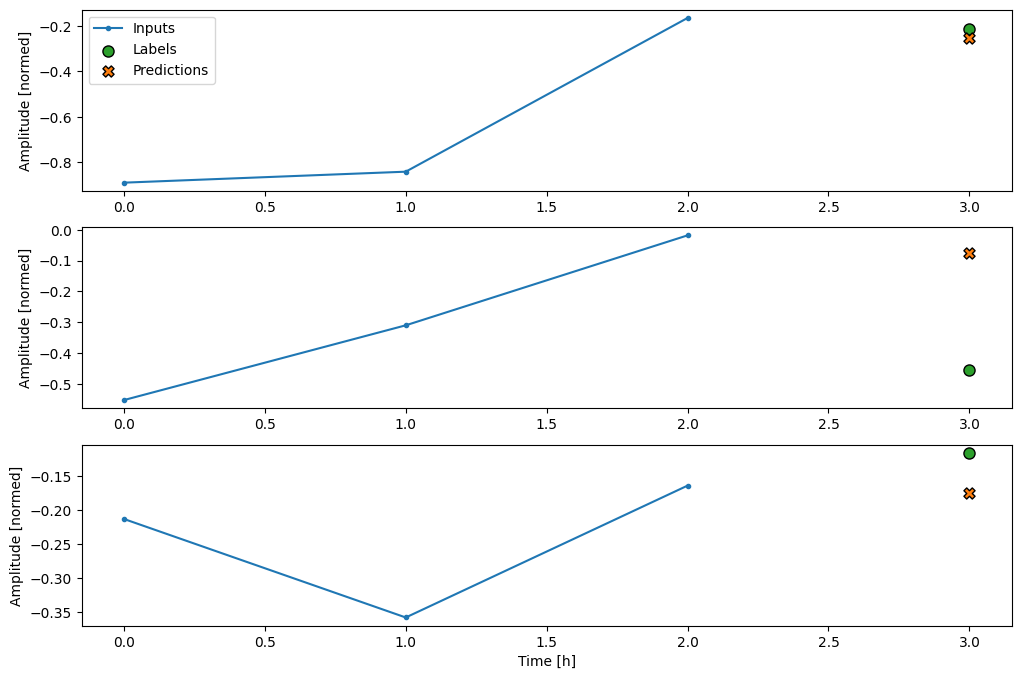

In [57]:
conv_window.plot(multi_step_dense)

In [54]:
# This method is only compatible with inputs of a specific shape.

print("Input shape:", wide_window.example[0].shape)
try:
    print("Output shape:", multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
    print(f"\n{type(e).__name__}:{e}")

Input shape: (32, 24, 1)

ValueError:Exception encountered when calling Sequential.call().

Input 0 of layer "dense_4" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (32, 24)

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 24, 1), dtype=float32)
  • training=None
  • mask=None


### Convolutional Neural Network


In [55]:
conv_model = tf.keras.Sequential(
    [
        tf.keras.layers.Conv1D(
            filters=32, kernel_size=(CONV_WIDTH,), activation="relu"
        ),
        tf.keras.layers.Dense(units=32, activation="relu"),
        tf.keras.layers.Dense(units=1),
    ]
)

In [56]:
print("Conv model on `conv_window`")
print("Input shape:", conv_window.example[0].shape)
print("Output shape:", conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 1)
Output shape: (32, 1, 1)


In [57]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance["Conv"] = conv_model.evaluate(conv_window.val, return_dict=True)
performance["Conv"] = conv_model.evaluate(conv_window.test, verbose=0, return_dict=True)

617/617 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0863 - mean_absolute_error: 0.2336


In [58]:
print("Wide window")
print("Input shape:", wide_window.example[0].shape)
print("Labels shape:", wide_window.example[1].shape)
print("Output shape:", conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 1)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


In [59]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=["Amplitude"],
)

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['Amplitude']

In [60]:
print("Wide conv window")
print("Input shape:", wide_conv_window.example[0].shape)
print("Labels shape:", wide_conv_window.example[1].shape)
print("Output shape:", conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 1)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


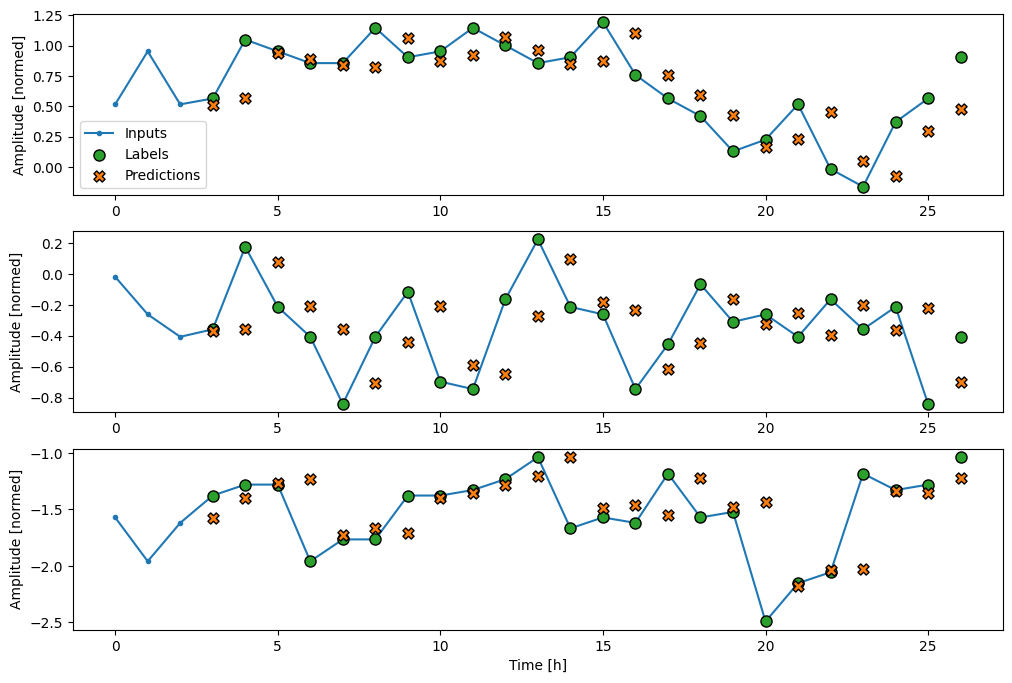

In [61]:
wide_conv_window.plot(conv_model)

### Recurrent Neural Network


In [62]:
lstm_model = tf.keras.models.Sequential(
    [
        # Shape [batch, time, features] => [batch, time, lstm_units]
        tf.keras.layers.LSTM(32, return_sequences=True),
        # Shape => [batch, time, features]
        tf.keras.layers.Dense(units=1),
    ]
)

In [63]:
print("Input shape:", wide_window.example[0].shape)
print("Output shape:", lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 1)
Output shape: (32, 24, 1)


In [64]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance["LSTM"] = lstm_model.evaluate(wide_window.val, return_dict=True)
performance["LSTM"] = lstm_model.evaluate(wide_window.test, verbose=0, return_dict=True)

617/617 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0840 - mean_absolute_error: 0.2305


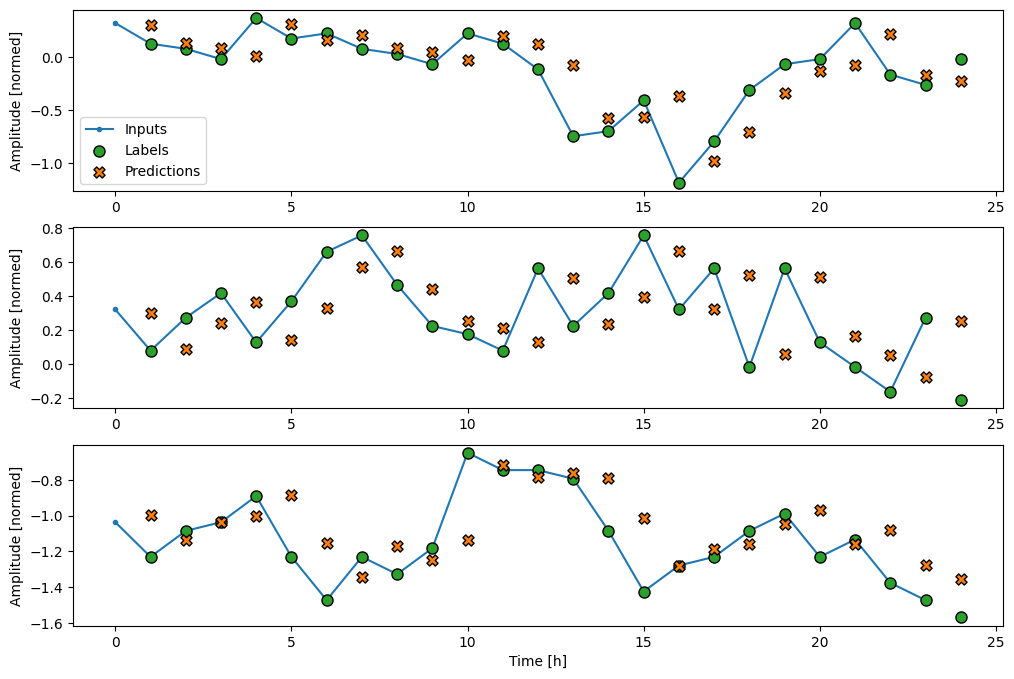

In [65]:
wide_window.plot(lstm_model)

### Performance


In [66]:
cm = lstm_model.metrics[1]
cm.metrics

[<MeanAbsoluteError name=mean_absolute_error>]

In [67]:
val_performance

{'Baseline': {'loss': 0.08846598118543625,
  'mean_absolute_error': 0.23533053696155548},
 'Linear': {'loss': 0.08653517812490463,
  'mean_absolute_error': 0.23365968465805054},
 'Dense': {'loss': 0.08753418922424316,
  'mean_absolute_error': 0.23544514179229736},
 'Multi step dense': {'loss': 0.08503373712301254,
  'mean_absolute_error': 0.23186348378658295},
 'Conv': {'loss': 0.08488086611032486,
  'mean_absolute_error': 0.23190507292747498},
 'LSTM': {'loss': 0.08381708711385727,
  'mean_absolute_error': 0.23030832409858704}}

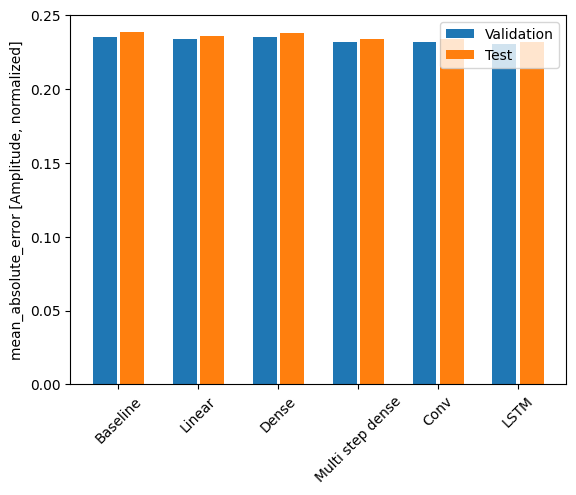

In [68]:
x = np.arange(len(performance))
width = 0.3
metric_name = "mean_absolute_error"
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.ylabel("mean_absolute_error [Amplitude, normalized]")
plt.bar(x - 0.17, val_mae, width, label="Validation")
plt.bar(x + 0.17, test_mae, width, label="Test")
plt.xticks(ticks=x, labels=performance.keys(), rotation=45)
_ = plt.legend()

In [69]:
for name, value in performance.items():
    print(f"{name:12s}: {value[metric_name]:0.4f}")

Baseline    : 0.2383
Linear      : 0.2362
Dense       : 0.2379
Multi step dense: 0.2337
Conv        : 0.2338
LSTM        : 0.2321


### Multi-output models


In [70]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you
    # don't set the `label_columns` argument.
    input_width=1,
    label_width=1,
    shift=1,
)

wide_window = WindowGenerator(input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
    print(f"Inputs shape (batch, time, features): {example_inputs.shape}")
    print(f"Labels shape (batch, time, features): {example_labels.shape}")

Inputs shape (batch, time, features): (32, 24, 1)
Labels shape (batch, time, features): (32, 24, 1)


#### Baseline


In [72]:
baseline = Baseline()
baseline.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()],
)

In [73]:
val_performance = {}
performance = {}
val_performance["Baseline"] = baseline.evaluate(wide_window.val, return_dict=True)
performance["Baseline"] = baseline.evaluate(
    wide_window.test, verbose=0, return_dict=True
)

617/617 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0886 - mean_absolute_error: 0.2354


#### Dense


In [74]:
dense = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(units=64, activation="relu"),
        tf.keras.layers.Dense(units=64, activation="relu"),
        tf.keras.layers.Dense(units=num_features),
    ]
)

#### RNN


In [75]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1
)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val, return_dict=True)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0, return_dict=True)

print()

617/617 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0866 - mean_absolute_error: 0.2337

CPU times: user 2min 34s, sys: 1min 25s, total: 4min
Wall time: 1min 40s


#### Advanced Residual Connections


In [76]:
class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)

        # The prediction for each time step is the input
        # from the previous time step plut the delta
        # calculated by the model.
        return inputs + delta

In [77]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
        tf.keras.layers.LSTM(32, return_sequences=True),
        tf.keras.layers.Dense(
            num_features, 
            # The predicted deltas should start small.
            # Therefore, initialize the output layer with zeros.
            kernel_initializer=tf.initializers.zeros()
        )
    ]
    )
)

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val, return_dict=True)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0, return_dict=True)
print()

617/617 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0834 - mean_absolute_error: 0.2297

CPU times: user 2min 55s, sys: 1min 10s, total: 4min 5s
Wall time: 2min 12s


#### Performance


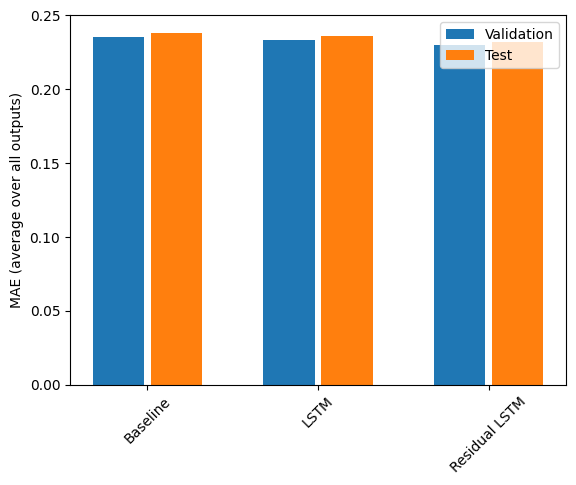

In [78]:
x = np.arange(len(performance))
width = 0.3

metric_name = "mean_absolute_error"
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label="Validation")
plt.bar(x + 0.17, test_mae, width, label="Test")
plt.xticks(ticks=x, labels=performance.keys(), rotation=45)
plt.ylabel("MAE (average over all outputs)")
_ = plt.legend()

In [79]:
for name, value in performance.items():
    print(f"{name:15s}: {value[metric_name]:0.4f}")

Baseline       : 0.2383
LSTM           : 0.2361
Residual LSTM  : 0.2320


### Multi-step models


Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

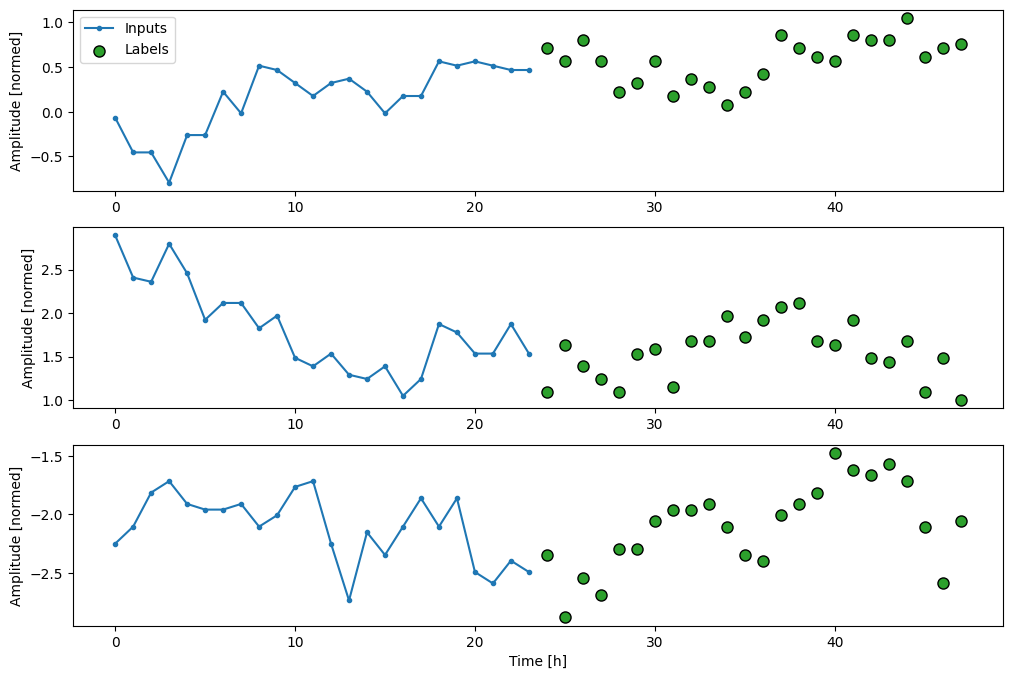

In [80]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24, label_width=OUT_STEPS, shift=OUT_STEPS)

multi_window.plot()
multi_window

In [81]:
class MultiStepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        tile = tf.tile(inputs[:, -1, :], [1, OUT_STEPS, 1])
        return tile

In [82]:
last_baseline = MultiStepLastBaseline()
last_baseline.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()],
)

In [83]:
multi_val_performance = {}
multi_performance = {}

In [86]:
multi_window.val

<_MapDataset element_spec=(TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>

In [85]:
# multi_val_performance["Last"] = last_baseline.evaluate(
#     multi_window.val, return_dict=True
# )
# multi_performance["Last"] = last_baseline.evaluate(
#     multi_window.test, verbose=0, return_dict=True
# )

ValueError: Exception encountered when calling MultiStepLastBaseline.call().

[1mShape must be rank 2 but is rank 3 for '{{node multi_step_last_baseline_1/Tile}} = Tile[T=DT_FLOAT, Tmultiples=DT_INT32](multi_step_last_baseline_1/strided_slice, multi_step_last_baseline_1/Tile/multiples)' with input shapes: [?,1], [3].[0m

Arguments received by MultiStepLastBaseline.call():
  • inputs=tf.Tensor(shape=(None, 24, 1), dtype=float32)

### Repeat Baseline


In [95]:
class RepeatBaseline(tf.keras.Model):
    def call(self, inputs):
        return inputs


repeat_baseline = RepeatBaseline()
repeat_baseline.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()],
)

616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5881 - mean_absolute_error: 0.6117


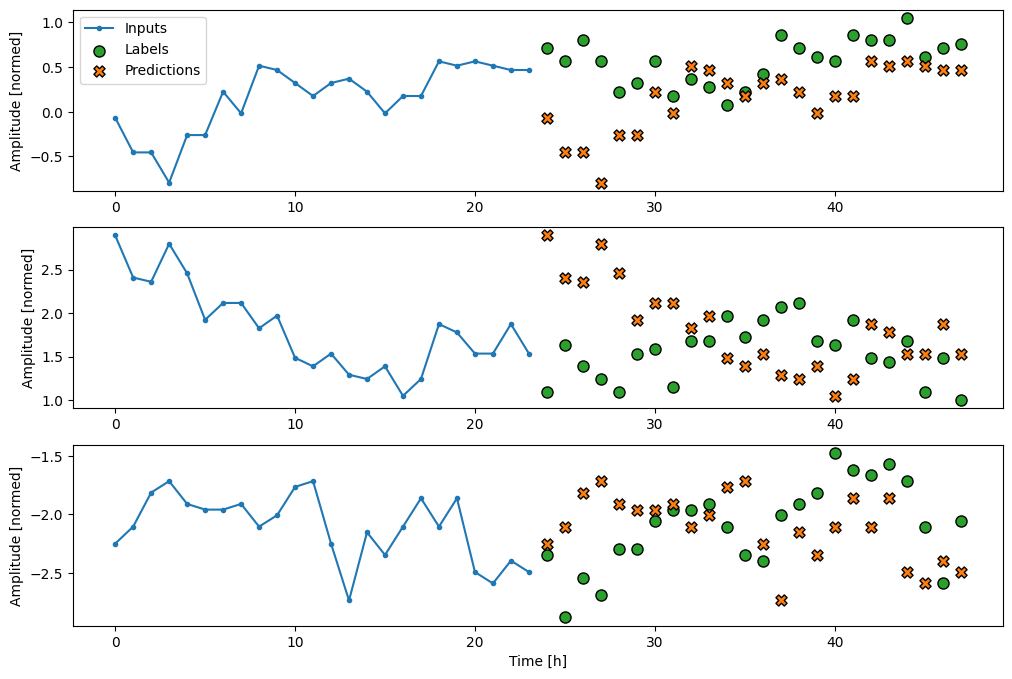

In [96]:
multi_val_performance["Repeat"] = repeat_baseline.evaluate(
    multi_window.val, return_dict=True
)
multi_performance["Repeat"] = repeat_baseline.evaluate(
    multi_window.test, verbose=0, return_dict=True
)
multi_window.plot(repeat_baseline)

### Single-shot models


616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3613 - mean_absolute_error: 0.4710


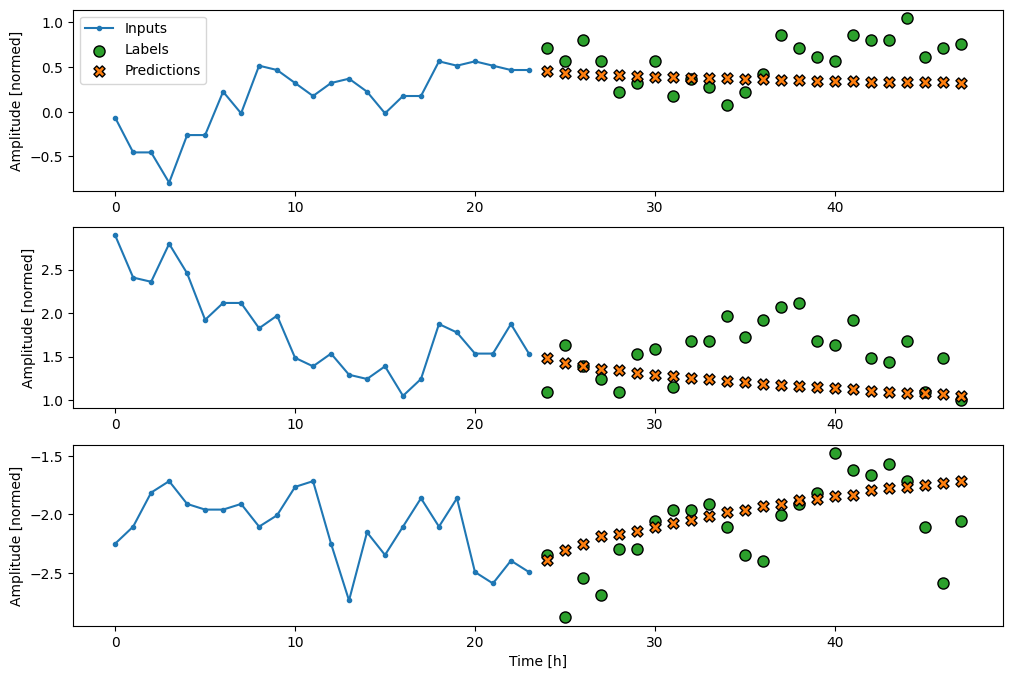

In [98]:
multi_linear_model = tf.keras.Sequential(
    [
        # Take the last time-step.
        # Shape [batch, time, features] => [batch, 1, features]
        tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
        # Shape => [batch, 1, out_steps*features]
        tf.keras.layers.Dense(
            OUT_STEPS * num_features, kernel_initializer=tf.initializers.zeros()
        ),
        # Shape => [batch, out_steps, features]
        tf.keras.layers.Reshape([OUT_STEPS, num_features]),
    ]
)

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance["Linear"] = multi_linear_model.evaluate(
    multi_window.val, return_dict=True
)
multi_performance["Linear"] = multi_linear_model.evaluate(
    multi_window.test, verbose=0, return_dict=True
)
multi_window.plot(multi_linear_model)

### Dense Multi-Output Model


In [104]:
multi_dense_model = tf.keras.Sequential(
    [
        # Take the last time step.
        # Shape [batch, time, features] => [batch, 1, features]
        tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
        # Shape => [batch, 1, dense_units]
        tf.keras.layers.Dense(512, activation="relu"),
        # Shape => [batch, out_steps*features]
        tf.keras.layers.Dense(
            OUT_STEPS * num_features, kernel_initializer=tf.initializers.zeros()
        ),
        # Shape => [batch, out_steps, features]
        tf.keras.layers.Reshape([OUT_STEPS, num_features]),
    ]
)

history = compile_and_fit(multi_dense_model, multi_window)

Epoch 1/20
2158/2158 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 0.4036 - mean_absolute_error: 0.4952 - val_loss: 0.3660 - val_mean_absolute_error: 0.4746
Epoch 2/20
2158/2158 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 0.3740 - mean_absolute_error: 0.4794 - val_loss: 0.3654 - val_mean_absolute_error: 0.4743
Epoch 3/20
2158/2158 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 0.3742 - mean_absolute_error: 0.4795 - val_loss: 0.3639 - val_mean_absolute_error: 0.4731
Epoch 4/20
2158/2158 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 0.3737 - mean_absolute_error: 0.4793 - val_loss: 0.3646 - val_mean_absolute_error: 0.4736
Epoch 5/20
2158/2158 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 0.3732 - mean_absolute_error: 0.4790 - val_loss: 0.3635 - val_mean_absolute_error: 0.4731
Epoch 6/20
2158/2158 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 0.3728 - mean_absolute_error: 0.4788 - val_loss: 0.3646 - val_mean_absolute_error: 0.4739
Epoch 7/20
2158/2158 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 0.3730 - mean_absol

616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3583 - mean_absolute_error: 0.4704


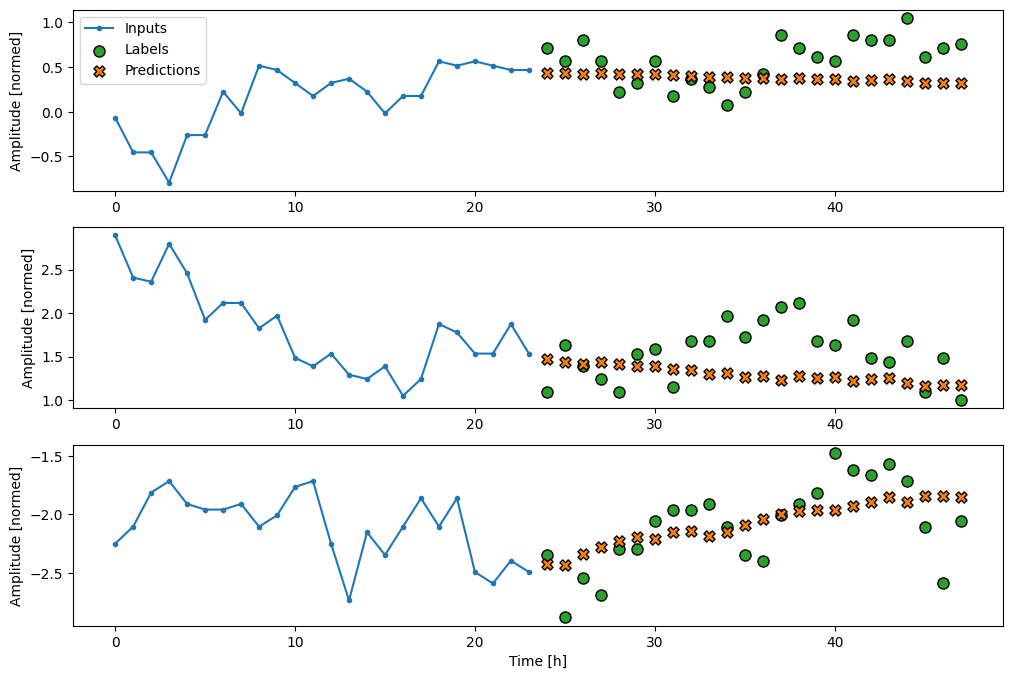

In [106]:
IPython.display.clear_output()
multi_val_performance["Dense"] = multi_dense_model.evaluate(
    multi_window.val, return_dict=True
)
multi_performance["Dense"] = multi_dense_model.evaluate(
    multi_window.test, verbose=0, return_dict=True
)
multi_window.plot(multi_dense_model)

#### CNN


616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3512 - mean_absolute_error: 0.4651


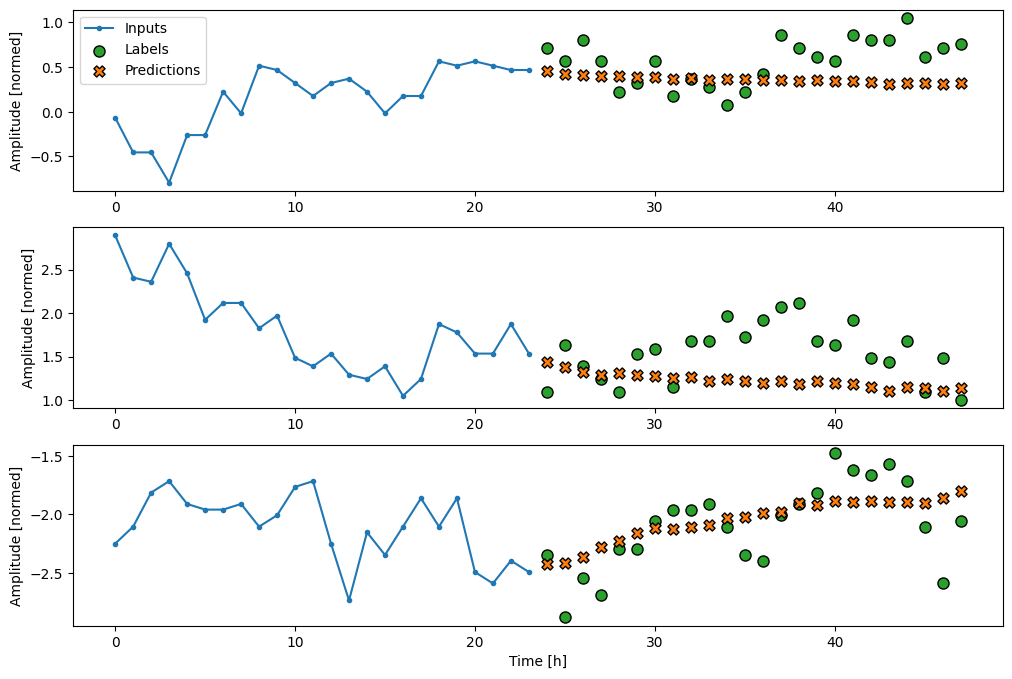

In [107]:
import IPython.display


CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential(
    [
        # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
        tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
        # Shape => [batch, 1, conv_units]
        tf.keras.layers.Conv1D(256, activation="relu", kernel_size=(CONV_WIDTH)),
        # Shape => [batch, 1, out_steps*features]
        tf.keras.layers.Dense(
            OUT_STEPS * num_features, kernel_initializer=tf.initializers.zeros()
        ),
        # Shape => [batch, out_steps, features]
        tf.keras.layers.Reshape([OUT_STEPS, num_features]),
    ]
)

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance["Conv"] = multi_conv_model.evaluate(
    multi_window.val, return_dict=True
)
multi_performance["Conv"] = multi_conv_model.evaluate(
    multi_window.test, verbose=0, return_dict=True
)
multi_window.plot(multi_conv_model)

616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3330 - mean_absolute_error: 0.4544


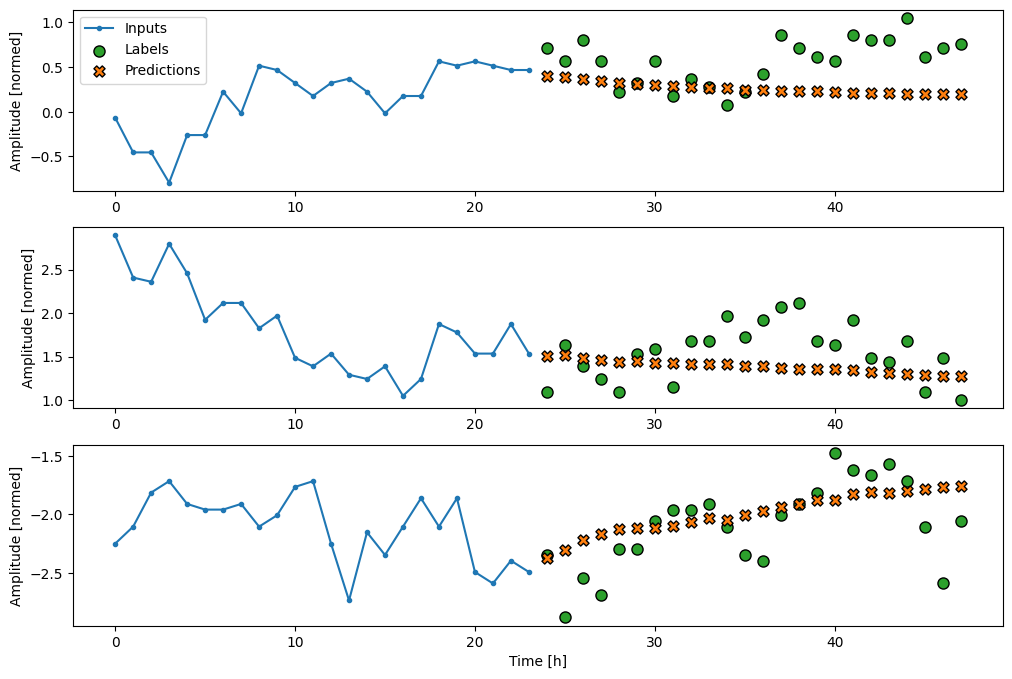

In [109]:
multi_lstm_model = tf.keras.Sequential(
    [
        # Shape [batch, time, features] => [batch, lstm_units].
        # Adding more`lstm_units` just overfits more quickly.
        tf.keras.layers.LSTM(32, return_sequences=False),
        # Shape => [batch, out_steps*features].
        tf.keras.layers.Dense(
            OUT_STEPS * num_features, kernel_initializer=tf.initializers.zeros()
        ),
        # Shape => [batch, out_steps, features].
        tf.keras.layers.Reshape([OUT_STEPS, num_features]),
    ]
)

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance["LSTM"] = multi_lstm_model.evaluate(
    multi_window.val, return_dict=True
)
multi_performance["LSTM"] = multi_lstm_model.evaluate(
    multi_window.test, verbose=0, return_dict=True
)
multi_window.plot(multi_lstm_model)

### Autoregressive model


#### RNN


In [112]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in a RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)

In [113]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [115]:
def warmup(self, inputs):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)

    # predictions.shape => (batch, features)
    prediction = self.dense(x)
    return prediction, state


FeedBack.warmup = warmup

In [116]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 1])

In [117]:
def call(self, inputs, training=None):
    # Use a TensorArray to capture dynamically unrolled outputs.
    predictions = []
    # Initialize the LSTM state.
    prediction, state = self.warmup(inputs)

    # Insert the first prediction
    predictions.append(prediction)

    # Run the rest of the prediction steps.
    for n in range(1, self.out_steps):
        # Use the last prediction as input.
        x = prediction
        # Execute one lstm step.
        x, state = self.lstm_cell(x, states=state, training=training)
        # Convert the lstm output to a prediction.
        prediction = self.dense(x)
        # add the prediction to the output.
        predictions.append(prediction)

    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions


FeedBack.call = call

In [118]:
print(
    "Output shape (batch, time, features): ",
    feedback_model(multi_window.example[0]).shape,
)

Output shape (batch, time, features):  (32, 24, 1)


In [119]:
history = compile_and_fit(feedback_model, multi_window)

Epoch 1/20


2024-09-05 17:02:34.768271: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INTERNAL: stream cannot wait for itself
	 [[{{node StatefulPartitionedCall/feed_back_1_1/rnn_1/while/body/_27/feed_back_1_1/rnn_1/while/gradient_tape/feed_back_1_1/rnn_1/while/gradients/feed_back_1_1/rnn_1/while/lstm_cell_1_1/add_grad/Shape/_80}}]]
2024-09-05 17:02:34.768569: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18028126173846208772
2024-09-05 17:02:34.768578: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11140773599482052953
2024-09-05 17:02:34.768598: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4539932138072998433
2024-09-05 17:02:34.768602: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8334799374674756261
2024-09-05 17:02:34.768607: I 

InternalError: Graph execution error:

Detected at node StatefulPartitionedCall/feed_back_1_1/rnn_1/while/body/_27/feed_back_1_1/rnn_1/while/gradient_tape/feed_back_1_1/rnn_1/while/gradients/feed_back_1_1/rnn_1/while/lstm_cell_1_1/add_grad/Shape/_80 defined at (most recent call last):
<stack traces unavailable>
Detected at node StatefulPartitionedCall/feed_back_1_1/rnn_1/while/body/_27/feed_back_1_1/rnn_1/while/gradient_tape/feed_back_1_1/rnn_1/while/gradients/feed_back_1_1/rnn_1/while/lstm_cell_1_1/add_grad/Shape/_80 defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) INTERNAL:  stream cannot wait for itself
	 [[{{node StatefulPartitionedCall/feed_back_1_1/rnn_1/while/body/_27/feed_back_1_1/rnn_1/while/gradient_tape/feed_back_1_1/rnn_1/while/gradients/feed_back_1_1/rnn_1/while/lstm_cell_1_1/add_grad/Shape/_80}}]]
	 [[StatefulPartitionedCall/gradient_tape/feed_back_1_1/rnn_1/while/feed_back_1_1/rnn_1/while_grad/body/_145/gradient_tape/feed_back_1_1/rnn_1/while/gradients/feed_back_1_1/rnn_1/while/TensorArrayV2Write/TensorListSetItem_grad/TensorListSetItem/Const/_288]]
  (1) INTERNAL:  stream cannot wait for itself
	 [[{{node StatefulPartitionedCall/feed_back_1_1/rnn_1/while/body/_27/feed_back_1_1/rnn_1/while/gradient_tape/feed_back_1_1/rnn_1/while/gradients/feed_back_1_1/rnn_1/while/lstm_cell_1_1/add_grad/Shape/_80}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_one_step_on_iterator_794233]

In [121]:
IPython.display.clear_output()

multi_val_performance["AR LSTM"] = feedback_model.evaluate(
    multi_window.val, return_dict=True
)

616/616 ━━━━━━━━━━━━━━━━━━━━ 40s 63ms/step - loss: 0.9761 - mean_absolute_error: 0.7838


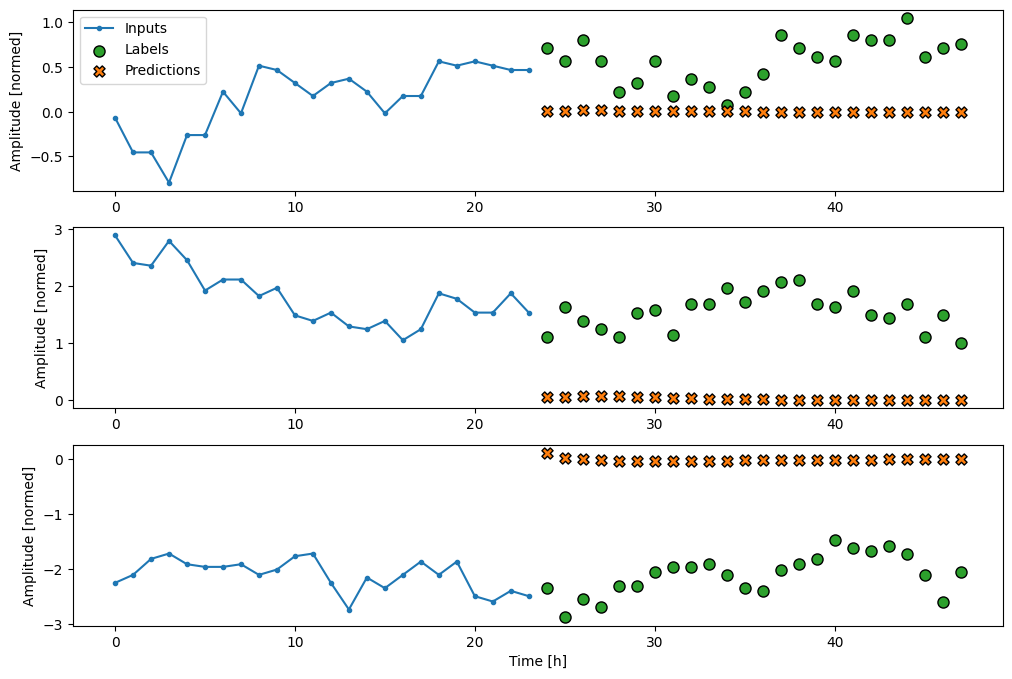

In [124]:
multi_performance["AR LSTM"] = feedback_model.evaluate(
    multi_window.test, verbose=0, return_dict=True
)
multi_window.plot(feedback_model)

#### Performance of the AutoRegressive Model


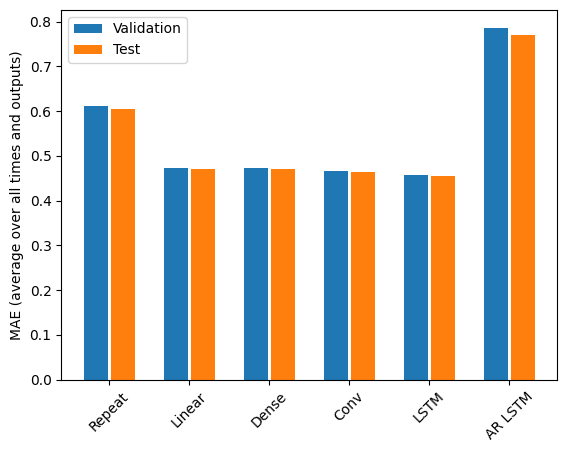

In [125]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = "mean_absolute_error"
val_mae = [v[metric_name] for v in multi_val_performance.values()]
test_mae = [v[metric_name] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label="Validation")
plt.bar(x + 0.17, test_mae, width, label="Test")
plt.xticks(ticks=x, labels=multi_performance.keys(), rotation=45)
plt.ylabel(f"MAE (average over all times and outputs)")
_ = plt.legend()

In [127]:
for name, value in multi_performance.items():
    print(f"{name:8s}: {value[metric_name]:0.4f}")

Repeat  : 0.6055
Linear  : 0.4701
Dense   : 0.4716
Conv    : 0.4647
LSTM    : 0.4556
AR LSTM : 0.7706


## GRU


### Example GRU


In [5]:
datapath = os.getcwd() + "/data/AMZN_2006-01-01_to_2018-01-01.csv"

In [6]:
datapath

'/Volumes/T7/Github/Neuralink-Compression-Challenge/analysis/tutorials/data/AMZN_2006-01-01_to_2018-01-01.csv'

In [7]:
data = pd.read_csv(datapath)
data = data.sort_values("Date")
data.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN
1,2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN
2,2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN
3,2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN
4,2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN


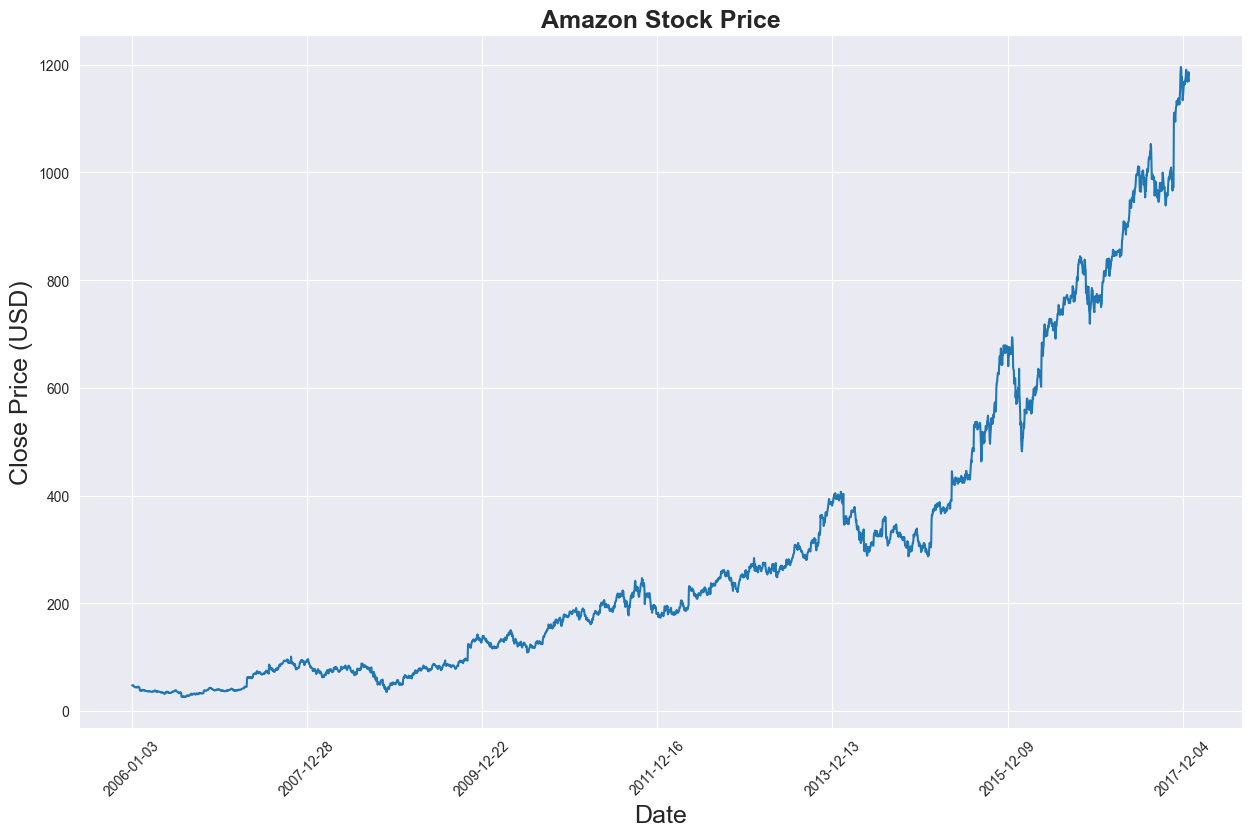

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
plt.figure(figsize=(15, 9))
plt.plot(data[["Close"]])
plt.xticks(range(0, data.shape[0], 500), data["Date"].loc[::500], rotation=45)
plt.title("Amazon Stock Price", fontsize=18, fontweight="bold")
plt.xlabel("Date", fontsize=18)
plt.ylabel("Close Price (USD)", fontsize=18)
plt.show()

##### Normalizing data


In [10]:
price = data[["Close"]]
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   3019 non-null   float64
dtypes: float64(1)
memory usage: 23.7 KB


In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
price["Close"] = scaler.fit_transform(price["Close"].values.reshape(-1, 1))

/var/folders/km/lr9wgyjj0z737tmwxblc5d980000gn/T/ipykernel_1695/2806466906.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price["Close"] = scaler.fit_transform(price["Close"].values.reshape(-1, 1))


In [17]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy()  # convert to numpy array
    data = []

    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index : index + lookback])

    data = np.array(data)
    test_set_size = int(np.round(0.2 * data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)

    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]

    x_test = data[train_set_size:, :-1]
    y_test = data[train_set_size:, -1, :]

    return [x_train, y_train, x_test, y_test]

In [14]:
import torch
import torch.nn as nn

In [18]:
lookback = 20  # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)
print("x_train.shape = ", x_train.shape)
print("y_train.shape = ", y_train.shape)
print("x_test.shape = ", x_test.shape)
print("y_test.shape = ", y_test.shape)

x_train.shape =  (2399, 19, 1)
y_train.shape =  (2399, 1)
x_test.shape =  (600, 19, 1)
y_test.shape =  (600, 1)


In [19]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [20]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [21]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [22]:
model = GRU(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    num_layers=num_layers,
)
criterion = torch.nn.MSELoss(reduction="mean")
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [25]:
hist = np.zeros(num_epochs)
start_time = time.time()
gru = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time() - start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.6688732504844666
Epoch  1 MSE:  0.3324863314628601
Epoch  2 MSE:  0.13513252139091492
Epoch  3 MSE:  0.037674739956855774
Epoch  4 MSE:  0.07518574595451355
Epoch  5 MSE:  0.09051577001810074
Epoch  6 MSE:  0.05012138560414314
Epoch  7 MSE:  0.0320722796022892
Epoch  8 MSE:  0.041110921651124954
Epoch  9 MSE:  0.05375426635146141
Epoch  10 MSE:  0.056260935962200165
Epoch  11 MSE:  0.048303425312042236
Epoch  12 MSE:  0.03596499189734459
Epoch  13 MSE:  0.026745568960905075
Epoch  14 MSE:  0.02605690434575081
Epoch  15 MSE:  0.03254926949739456
Epoch  16 MSE:  0.03667745739221573
Epoch  17 MSE:  0.03238367289304733
Epoch  18 MSE:  0.02432762086391449
Epoch  19 MSE:  0.019509004428982735
Epoch  20 MSE:  0.01979304477572441
Epoch  21 MSE:  0.022298486903309822
Epoch  22 MSE:  0.02312248758971691
Epoch  23 MSE:  0.02026662975549698
Epoch  24 MSE:  0.014778431504964828
Epoch  25 MSE:  0.010212480090558529
Epoch  26 MSE:  0.009906833060085773
Epoch  27 MSE:  0.0119237266480

In [27]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train.detach().numpy()))

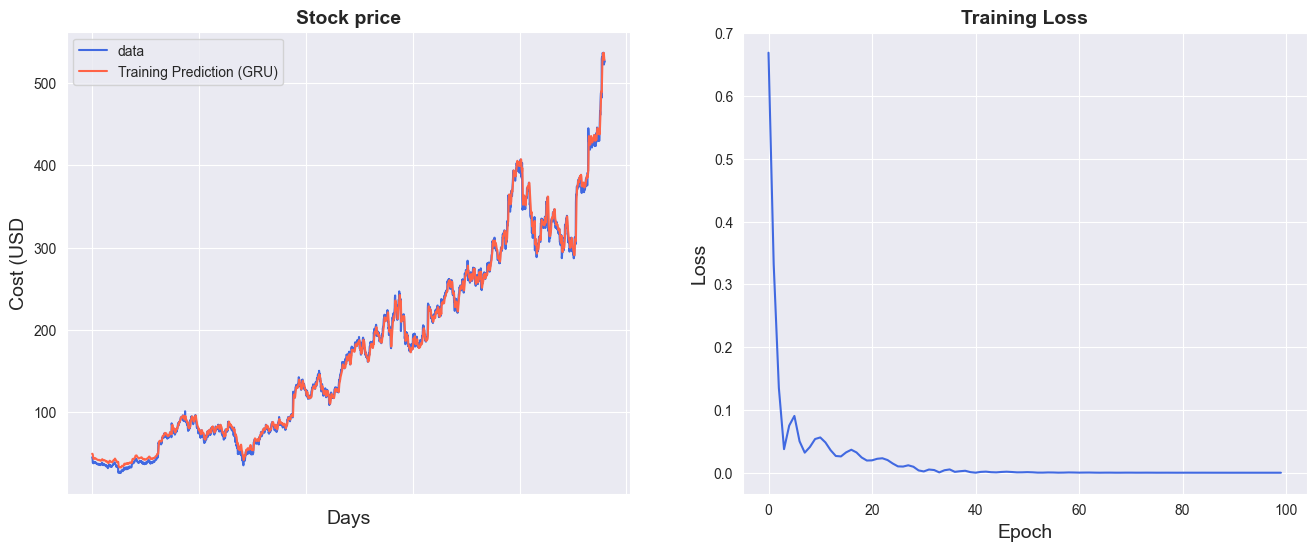

In [29]:
import seaborn as sns

sns.set_style("darkgrid")

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x=original.index, y=original[0], label="data", color="royalblue")
ax = sns.lineplot(
    x=predict.index, y=predict[0], label="Training Prediction (GRU)", color="tomato"
)
ax.set_title("Stock price", size=14, fontweight="bold")
ax.set_xlabel("Days", size=14)
ax.set_ylabel("Cost (USD", size=14)
ax.set_xticklabels("", size=10)

plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color="royalblue")
ax.set_xlabel("Epoch", size=14)
ax.set_ylabel("Loss", size=14)
ax.set_title("Training Loss", size=14, fontweight="bold")
fig.set_figheight(6)
fig.set_figwidth(16)

In [30]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:, 0], y_train_pred[:, 0]))
print("Train Score: %.2f RMSE" % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:, 0], y_test_pred[:, 0]))
print("Test Score: %.2f RMSE" % (testScore))
gru.append(trainScore)
gru.append(testScore)
gru.append(training_time)

Train Score: 5.80 RMSE
Test Score: 71.02 RMSE


In [31]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback : len(y_train_pred) + lookback, :] = y_train_pred

# shift test prediction for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred) + lookback - 1 : len(price) - 1, :] = y_test_pred

original = scaler.inverse_transform(price["Close"].values.reshape(-1, 1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)